# Case de Recomendação usando Market Basket Analysis para Live Class FIAP
# Dezembro/2022 - Janeiro/2023
## Instrutor: Bruno Curtarelli (Head of Data Science - Petlove & Co)

### Currículo
- Estatística Unicamp
- MBA gestão FIA/PROVAR
- Especializações em Machine Learning e Deep Learning - Andrew Ng (coursera)

### Experiência
- Data Scientist Nielsen
- Head Data Science Behup
- Head Data Science e fundador do primeiro time de dados da Petlove em 2018

Atualmente trabalhando com foco em Planejamento e Ressuprimento, desenvolvendo produtos de dados para previsão de demanda e sugestão de compra, além de robôs para monitorar todo o processo e auxiliar na melhoria contínua dos principais indicadores da companhia

Encontro do time de Digital da Petlove & Co

<img src="bruno.jpg" alt=![bruno.jpg] align="left" width="700" height="700" />

## Contexto do Problema que veremos hoje: e-commerce / varejista

### Dados disponíveis:
- Transações por cliente com lista de produtos

### O que gostaríamos de ter?
- Entender quais produtos são comprados frequentemente juntos
- Quais produtos podem alavancar as vendas de outros produtos

### Como usamos isso na prática?
- Sugerir no carrinho outros produtos para os clientes
- Definir sortimento de página de produtos, colocando produtos correlacionados próximos uns dos outros
- Ações de CRM para impulsionar venda
- Ofertar de forma assertiva produtos para incremento de vendas, vendas cruzadas

### Pacotes iniciais
Posteriormente importaremos os pacotes para aplicação do algoritmo de market basket analysis usando o apyori

In [1]:
import pandas as pd
import numpy as np
import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from matplotlib_venn import venn2

from IPython.display import Markdown as md

import warnings
warnings.filterwarnings('ignore')

### Leitura dos dados
Obtidos em:

https://www.kaggle.com/datasets/aslanahmedov/market-basket-analysis?select=Assignment-1_Data.csv
https://www.kaggle.com/datasets/sivaram1987/association-rule-learningapriori?resource=download

In [28]:
df = pd.read_csv('Market_Basket_Optimisation.csv', low_memory=False, header=None)

### Descrição dos Dados

Matriz de transações x produtos

- Transações nas linhas
- Produtos nas Colunas


- transaction_id: código da transação
- product: descritivo do produto
- quantity: quantidade comprada
- date: timestamp com a data e hora da transação
- price: preço unitário do produto
- customer_id: código de identificação do cliente
- country: país de residência do cliente

In [7]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,shrimp,almonds,avocado,vegetables mix,green grapes,whole weat flour,yams,cottage cheese,energy drink,tomato juice,low fat yogurt,green tea,honey,salad,mineral water,salmon,antioxydant juice,frozen smoothie,spinach,olive oil
1,burgers,meatballs,eggs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,chutney,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,turkey,avocado,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,mineral water,milk,energy bar,whole wheat rice,green tea,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Com a função "describe" podemos ver a contagem dos campos numéricos e suas distribuições

In [8]:
df.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
count,7501,5747,4389,3345,2529,1864,1369,981,654,395,256,154,87,47,25,8,4,4,3,1
unique,115,117,115,114,110,106,102,98,88,80,66,50,43,28,19,8,3,3,3,1
top,mineral water,mineral water,mineral water,mineral water,green tea,french fries,green tea,green tea,green tea,green tea,low fat yogurt,green tea,green tea,green tea,magazines,salmon,frozen smoothie,protein bar,spinach,olive oil
freq,577,484,375,201,153,107,96,67,57,31,22,15,8,4,3,1,2,2,1,1


### Com a função "info" podemos ver a tipagem das colunas

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7501 entries, 0 to 7500
Data columns (total 20 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       7501 non-null   object
 1   1       5747 non-null   object
 2   2       4389 non-null   object
 3   3       3345 non-null   object
 4   4       2529 non-null   object
 5   5       1864 non-null   object
 6   6       1369 non-null   object
 7   7       981 non-null    object
 8   8       654 non-null    object
 9   9       395 non-null    object
 10  10      256 non-null    object
 11  11      154 non-null    object
 12  12      87 non-null     object
 13  13      47 non-null     object
 14  14      25 non-null     object
 15  15      8 non-null      object
 16  16      4 non-null      object
 17  17      4 non-null      object
 18  18      3 non-null      object
 19  19      1 non-null      object
dtypes: object(20)
memory usage: 1.1+ MB


In [9]:
df.shape

(7501, 20)

In [31]:
# produtos distintos

df.melt()['value'].nunique()

120

In [13]:
lista = []
for i in range(1,len(df)):
    lista.append([str(df.values[i,j]) for j in range(0,20) if df.values[i,j] is not np.nan])

In [14]:
lista

[['burgers', 'meatballs', 'eggs'],
 ['chutney'],
 ['turkey', 'avocado'],
 ['mineral water', 'milk', 'energy bar', 'whole wheat rice', 'green tea'],
 ['low fat yogurt'],
 ['whole wheat pasta', 'french fries'],
 ['soup', 'light cream', 'shallot'],
 ['frozen vegetables', 'spaghetti', 'green tea'],
 ['french fries'],
 ['eggs', 'pet food'],
 ['cookies'],
 ['turkey', 'burgers', 'mineral water', 'eggs', 'cooking oil'],
 ['spaghetti', 'champagne', 'cookies'],
 ['mineral water', 'salmon'],
 ['mineral water'],
 ['shrimp',
  'chocolate',
  'chicken',
  'honey',
  'oil',
  'cooking oil',
  'low fat yogurt'],
 ['turkey', 'eggs'],
 ['turkey',
  'fresh tuna',
  'tomatoes',
  'spaghetti',
  'mineral water',
  'black tea',
  'salmon',
  'eggs',
  'chicken',
  'extra dark chocolate'],
 ['meatballs', 'milk', 'honey', 'french fries', 'protein bar'],
 ['red wine', 'shrimp', 'pasta', 'pepper', 'eggs', 'chocolate', 'shampoo'],
 ['rice', 'sparkling water'],
 ['spaghetti', 'mineral water', 'ham', 'body spray',

In [21]:
from apyori import apriori

arules = apriori(lista, min_support=0.003, min_confidence=0.2,
                            min_lift=2, min_length=2)
results = list(arules)

In [22]:
len(results)

346

## Limpeza de dados faltantes, ajuste de tipos e criação das demais variáveis

### Remoção de clientes e produtos faltantes

In [12]:
df_clean = df.loc[(df['customer_id'].notna()) & (df['product'].notna())].copy()

In [13]:
df_clean['total_value'] = df_clean['quantity']*df_clean['price']

### Ajustes nos tipos de datas
Como os dados eram antigos, fiz um ajuste nas datas (+10 anos) apenas para trazer mais ao presente

In [14]:
df_clean['date'] = pd.to_datetime(df_clean['date']).dt.date + pd.offsets.DateOffset(years=10)

### Contagem de casos distintos por variável

In [15]:
df_clean.nunique()

transaction_id    18163
product            3846
quantity            300
date                305
price               436
customer_id        4297
country              29
total_value        2901
dtype: int64

# Análises Descritivas

### TOP 10 Países na base de dados - em número de clientes

### Função para agregação dos dados por países e criação de estatísticas

In [16]:
def country_agg(x):
    names = {
        'transactions': x['transaction_id'].nunique()
        , 'customers': x['customer_id'].nunique()
        , 'total_sales': x['total_value'].sum()
        , 'average_ticket': x['total_value'].sum()/x['transaction_id'].nunique()
        , 'distinct_products': x['product'].nunique()
        , 'total_quantity': x['quantity'].sum()
        , 'average_products_per_transaction': x['product'].count()/x['transaction_id'].nunique()
        , 'average_quantity': x['quantity'].sum()/x['transaction_id'].nunique()
    }
    return pd.Series(names, index=['transactions'
                                  , 'customers'
                                  , 'total_sales'
                                  , 'average_ticket'
                                  , 'distinct_products'
                                  , 'total_quantity'
                                  , 'average_products_per_transaction'
                                  , 'average_quantity'
                                  ])

## Podemos notar que a maior parte das transações estão no Reino Unido
- Suiça é o pais com maior ticket médio e maior número de produtos por pedido
- Espanha e Italia são os países de menor ticket e produtos por pedido

In [17]:
top_countries = df_clean.groupby('country').apply(country_agg).sort_values('customers', ascending=False)
top_countries['customer_percent'] = top_countries['customers']/top_countries['customers'].sum()*100
top_countries.head(10)

,transactions,customers,total_sales,average_ticket,distinct_products,total_quantity,average_products_per_transaction,average_quantity,customer_percent
country,,,,,,,,,
United Kingdom,16649.0,3921.0,7308391.554,438.968800,3833.0,4269472.0,21.283260,256.440147,91.186047
Germany,457.0,94.0,228867.140,500.803370,1695.0,119263.0,19.785558,260.969365,2.186047
France,389.0,87.0,209024.050,537.336889,1543.0,111472.0,21.444730,286.560411,2.023256
Spain,90.0,30.0,61577.110,684.190111,1104.0,27951.0,27.611111,310.566667,0.697674
Belgium,98.0,25.0,41196.340,420.370816,784.0,23237.0,20.724490,237.112245,0.581395
Switzerland,51.0,21.0,56443.950,1106.744118,954.0,30083.0,36.117647,589.862745,0.488372
Portugal,57.0,19.0,33439.890,586.664737,693.0,16122.0,25.649123,282.842105,0.441860
Italy,38.0,14.0,17483.240,460.085263,476.0,8112.0,19.947368,213.473684,0.325581
Austria,17.0,11.0,10198.680,599.922353,306.0,4881.0,23.411765,287.117647,0.255814


## Principais produtos

In [19]:
def product_agg(x):
    names = {
        'transactions': x['transaction_id'].nunique()
        , 'customers': x['customer_id'].nunique()
        , 'total_sales': x['total_value'].sum()
        , 'total_quantity': x['quantity'].sum()
        , 'average_quantity': x['quantity'].sum()/x['transaction_id'].nunique()
    }
    return pd.Series(names, index=['transactions'
                                  , 'customers'
                                  , 'total_sales'
                                  , 'total_quantity'
                                  , 'average_quantity'
                                  ])

In [20]:
top_products = df_clean.groupby('product').apply(product_agg).sort_values('transactions', ascending=False)
top_products['transactions_percent'] = top_products['transactions']/top_products['transactions'].sum()*100
top_products.head(10)

,transactions,customers,total_sales,total_quantity,average_quantity,transactions_percent
product,,,,,,
WHITE HANGING HEART T-LIGHT HOLDER,1919.0,844.0,96931.55,35425.0,18.460135,0.507894
REGENCY CAKESTAND 3 TIER,1627.0,869.0,134253.10,11679.0,7.178242,0.430611
JUMBO BAG RED RETROSPOT,1573.0,627.0,84316.26,45715.0,29.062301,0.416319
ASSORTED COLOUR BIRD ORNAMENT,1358.0,673.0,56080.10,35066.0,25.821797,0.359416
PARTY BUNTING,1352.0,698.0,66771.83,14821.0,10.962278,0.357828
LUNCH BAG RED RETROSPOT,1266.0,526.0,27182.80,17136.0,13.535545,0.335067
SET OF 3 CAKE TINS PANTRY DESIGN,1112.0,632.0,31258.45,6547.0,5.887590,0.294308
POSTAGE,1043.0,311.0,72663.02,2972.0,2.849473,0.276046
LUNCH BAG BLACK SKULL.,1039.0,453.0,17727.55,11111.0,10.693936,0.274988


# Recomendação de Produtos usando Market Basket Analysis (análise de cesta de produtos)

## Técnica utilizada para descobrir regras de assoçiação de produtos

## Algoritmo - Apriori:
### Método de aprendizado de máquina baseado em regras de associação para encontrar relacionamentos relevantes entre produtos em grandes dimensões de dados. Utiliza conjunto de dados transacionais, como exemplo, lista de produtos comprados por cada cliente numa transação

### Imagine que você disponha de todas as transações (carrinhos) e produtos comprados pelos clientes da sua loja.
### O número de combinações de produtos ou skus/eans são infinitos. Como entender quais combinações (ou associações) de produtos são relevantes, ou mais acontecem?

### Qual é a probabilidade de um produto X ser comprado, dado que o cliente está levando Y?

### Podemos imaginar que um cliente que colocou em seu carrinho macarrão e molho de tomate, também tenha uma alta probabilidade de comprar um queijo ralado, ou talvez um vinho? Quão relevantes são essas associações?

### São estes tipos de perguntas que a análise de cestas pode ajudar a responder

Exemplos de cestas de produtos

<img src="basket.jpg" alt=![basket.jpg] align="left" width="900" height="700" />

## Podemos, por exemplo, entender qual é a probabilidade de um cliente comprar cerveja, numa visita ao mercado, uma vez que ele está comprando fraldas?

## Imagine que os produtos de um mercado estão dispostos em colunas de uma tabela e para cada cesta ou carrinho nas linhas, há uma marcação com 0 e 1 para indicar a ausência ou presença de cada item no respectivo carrinho.

## Esses vetores booleanos podem ser estudados para encontrarmos padrões que indiquem quais produtos são comprados frequentemente juntos. Estes padrões são representados com regras de associações.

In [204]:
carts_example = {'carrinho 1':{'pão':1, 'leite':1, 'queijo':1, 'fralda':0, 'cerveja':0, 'batata':0, 'carrinhos':1}
                ,'carrinho 2':{'pão':0, 'leite':0, 'queijo':0, 'fralda':1, 'cerveja':1, 'batata':1, 'carrinhos':1}
                ,'carrinho 3':{'pão':0, 'leite':0, 'queijo':1, 'fralda':1, 'cerveja':1, 'batata':0, 'carrinhos':1}
                ,'carrinho 4':{'pão':1, 'leite':0, 'queijo':1, 'fralda':0, 'cerveja':1, 'batata':0, 'carrinhos':1}
                ,'carrinho 5':{'pão':1, 'leite':0, 'queijo':1, 'fralda':1, 'cerveja':1, 'batata':0, 'carrinhos':1}
                ,'carrinho 6':{'pão':0, 'leite':0, 'queijo':0, 'fralda':0, 'cerveja':0, 'batata':0, 'carrinhos':1}
                ,'carrinho 7':{'pão':0, 'leite':0, 'queijo':0, 'fralda':0, 'cerveja':0, 'batata':0, 'carrinhos':1}
                ,'carrinho 8':{'pão':0, 'leite':0, 'queijo':0, 'fralda':0, 'cerveja':0, 'batata':0, 'carrinhos':1}
                ,'carrinho 9':{'pão':0, 'leite':0, 'queijo':0, 'fralda':0, 'cerveja':0, 'batata':0, 'carrinhos':1}
                ,'carrinho 10':{'pão':0, 'leite':0, 'queijo':0, 'fralda':0, 'cerveja':0, 'batata':0, 'carrinhos':1}
                }

print(pd.DataFrame(carts_example).T.to_markdown())

|             |   pão |   leite |   queijo |   fralda |   cerveja |   batata |   carrinhos |
|:------------|------:|--------:|---------:|---------:|----------:|---------:|------------:|
| carrinho 1  |     1 |       1 |        1 |        0 |         0 |        0 |           1 |
| carrinho 2  |     0 |       0 |        0 |        1 |         1 |        1 |           1 |
| carrinho 3  |     0 |       0 |        1 |        1 |         1 |        0 |           1 |
| carrinho 4  |     1 |       0 |        1 |        0 |         1 |        0 |           1 |
| carrinho 5  |     1 |       0 |        1 |        1 |         1 |        0 |           1 |
| carrinho 6  |     0 |       0 |        0 |        0 |         0 |        0 |           1 |
| carrinho 7  |     0 |       0 |        0 |        0 |         0 |        0 |           1 |
| carrinho 8  |     0 |       0 |        0 |        0 |         0 |        0 |           1 |
| carrinho 9  |     0 |       0 |        0 |        0 |         0 |   

### Alguns artigos e posts sobre o tema

https://www.analyticsvidhya.com/blog/2021/10/a-comprehensive-guide-on-market-basket-analysis/

https://towardsdatascience.com/a-gentle-introduction-on-market-basket-analysis-association-rules-fa4b986a40ce

https://techbusinessguide.com/what-is-lift-in-market-basket-analysis/

## Imagine que temos 1000 carrinhos e queremos avaliar a associação de Fraldas com Cerveja através de 3 métricas descritas à seguir.

### Métrica 1) Support:

Quão frequente a associação acontece no conjunto de dados?

Qual a frequência de carrinhos que possuem  fraldas e cerveja juntos?

$$ Support = {freq(Fralda, Cerveja) \over Carrinhos} $$

### A figura abaixo mostra que dos 1000 carrinhos, 100 possuem a combinação de fralda com cerveja. Logo temos um suporte de 100/1000, ou seja 0.1 de suporte

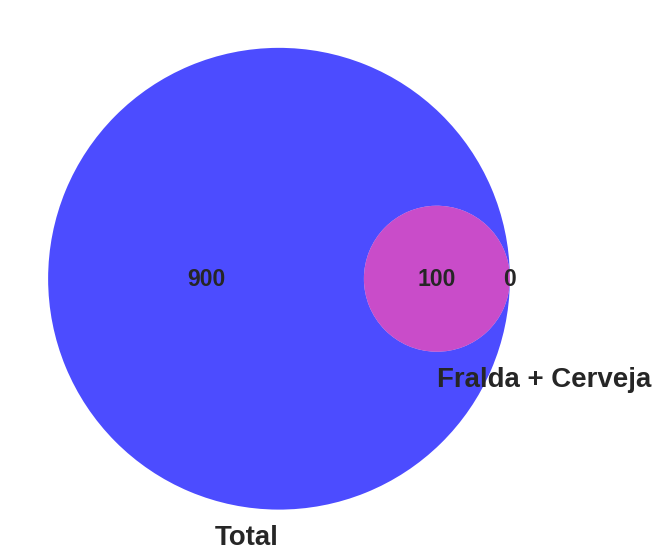

In [244]:
plt.figure(figsize=(15,10))
plt.style.use('seaborn')
venn2(
   subsets=(900, 0, 100),
   set_labels=['Total', 'Fralda + Cerveja'],
   alpha = .7,
   set_colors=['blue', 'red']
 )
plt.show()

### Métrica 2) Confidence:

Quão forte é a regra de associação?

Qual é a probabilidade de alguém comprar cerveja dado que ela comprou fralda?

$$ Confidence = {freq(Fralda, Cerveja) \over freq(Fralda)} $$

### Do total de 300 transações que contém Fralda, 100 delas também contém cerveja. Então temos uma confiança de 100/300, ou 0.33

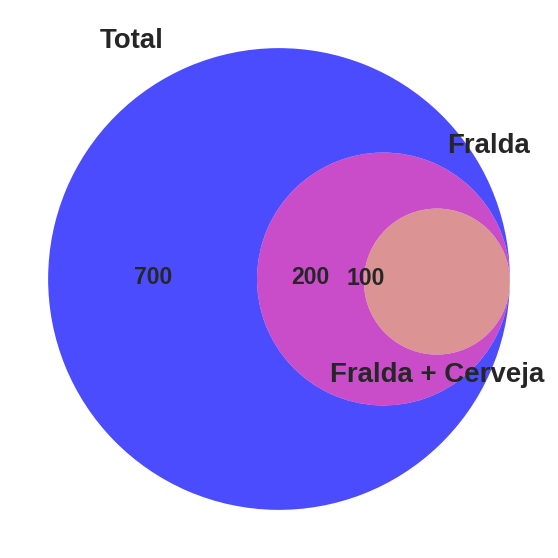

In [247]:
plt.figure(figsize=(15,10))
plt.style.use('seaborn')
venn3(
    # (Set1,Set2,1n2,Set3,1n3,2n3,1n2n3)
    subsets=(700, 0, 200, 0, 0, 0, 100),
   set_labels=['Total','Fralda','Fralda + Cerveja'],
    alpha = .7,
    set_colors=['blue', 'red', 'yellow']
 )
plt.show()

### Métrica 3) Lift:

Qual é a performance da regra de associação?

$$ Lift = {{freq(Fralda, Cerveja) \over Carrinhos} \over {{freq(Fralda) \over Carrinhos} {freq(Cerveja) \over Carrinhos}}} $$

### O lift (ou incremental) pode estar descrito por 2 casos especiais:

1. O item A e o item B (no exemplo Fralda e Cerveja) são independentes, ou seja, a probabilidade de um carrinho conter Fralda e Cerveja é igual a probabilidade de conter fralda ou a probabilidade de conter cerveja. P(A/B) = P(A) ou P(B/A) = P(B)
2. O item A e B são mutuamente exclusivos, então a probabilidade de um carrinho conter Fralda e Cerveja = 0

No Primeiro caso o lift será sempre maior, ou muito próximo a 1. Enquanto o segundo caso o lift é próximo ou muito menor do que 1.

### Exemplo 1: Probabilidade de comprar Fralda e Cerveja é igual a probabilidade de comprar Fralda x Probabilidade de Comprar Cerveja e a probabilidade de comprar Cerveja é bem alta

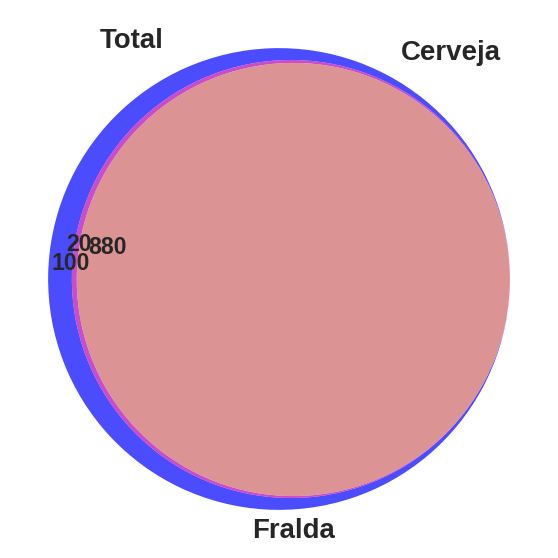

In [272]:
plt.figure(figsize=(15,10))
plt.style.use('seaborn')
venn3(
    # (Set1,Set2,1n2,Set3,1n3,2n3,1n2n3)
    subsets=(100, 0, 20, 0, 0, 0, 880),
   set_labels=['Total','Cerveja','Fralda'],
    alpha = .7,
    set_colors=['blue', 'red', 'yellow']
 )
plt.show()

$$ {P(Fralda, Cerveja) \over {P(Fralda) P(Cerveja)}} = {P(Fralda) \over{P(Fralda) P(Cerveja)}} =  {1 \over P(Cerveja)}$$

### Como P(Cerveja) é de 880/1000 = 0.88 e P(Fralda, Cerveja) = P(Fralda), então o lift acaba sendo 1/0.88, ou 1.14

### Exemplo 2: Probabilidade de comprar Fralda e Cerveja é igual a probabilidade de comprar Fralda x Probabilidade de Comprar Cerveja e a probabilidade de comprar Cerveja é bem baixa

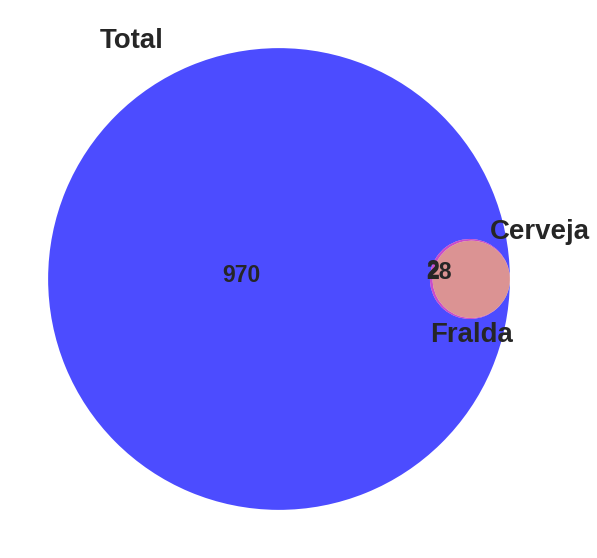

In [271]:
plt.figure(figsize=(15,10))
plt.style.use('seaborn')
venn3(
    # (Set1,Set2,1n2,Set3,1n3,2n3,1n2n3)
    subsets=(970, 0, 2, 0, 0, 0, 28),
   set_labels=['Total','Cerveja','Fralda'],
    alpha = .7,
    set_colors=['blue', 'red', 'yellow']
 )
plt.show()

### Como P(Cerveja) é de 30/1000 = 0.03 e P(Fralda, Cerveja) = P(Fralda), então o lift acaba sendo 1/0.03, ou 33.3. Em outras palavras, comprar cerveja é bem raro, mas quando ela acontece, Fralda acaba acontecendo junto também.

### Exemplo 3: Probabilidade de comprar Fralda e Cerveja é bem pequena ou quase nem existe

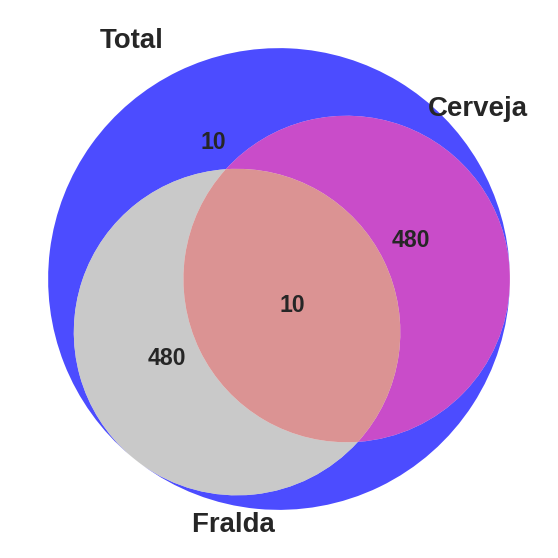

In [270]:
plt.figure(figsize=(15,10))
plt.style.use('seaborn')
venn3(
    # (Set1,Set2,1n2,Set3,1n3,2n3,1n2n3)
    subsets=(10, 0, 480, 0, 480, 0, 10),
   set_labels=['Total','Cerveja','Fralda '],
    alpha = .7,
    set_colors=['blue', 'red', 'yellow']
 )
plt.show()

### P(Fralda, Cerveja) = 10/1000 = 0.01. A P(Fralda) = 490/1000 = 0.49 e P(Cerveja) = 490/1000 = 0.49 também.
### Logo o lift seria 0.01/0.2 = 0.05, ou seja, um valor bem abaixo de 1

### Exemplo 4: Probabilidade de comprar Fralda e Cerveja é bem pequena ou quase nem existe e a probabilidade de comprar cerveja é baixa

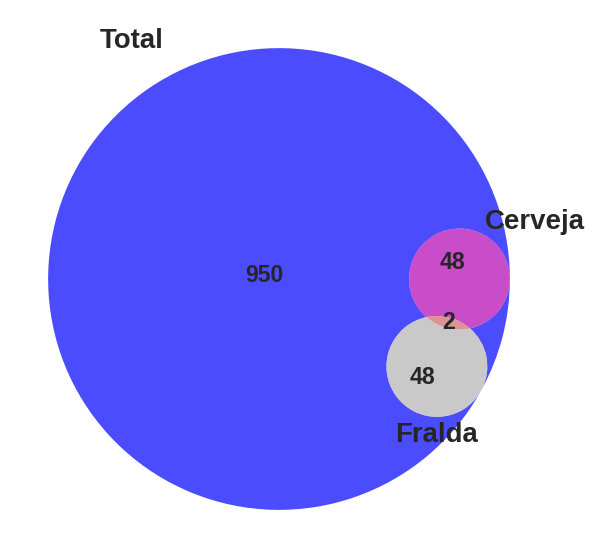

In [273]:
plt.figure(figsize=(15,10))
plt.style.use('seaborn')
venn3(
    # (Set1,Set2,1n2,Set3,1n3,2n3,1n2n3)
    subsets=(950, 0, 48, 0, 48, 0, 2),
   set_labels=['Total','Cerveja','Fralda'],
    alpha = .7,
    set_colors=['blue', 'red', 'yellow']
 )
plt.show()

### P(Fralda, Cerveja) = 2/1000 = 0.002. A P(Fralda) = 50/1000 = 0.05 e P(Cerveja) = 50/1000 = 0.05 também.
### Logo o lift seria 0.002 / 0.0025, ou seja, um valor bem próximo de 1, ou seja, sem incrementalidade

## Em Resumo:

In [ ]:
df.groupby([col1, col2]).size().unstack(fill_value=0)

In [331]:
lift_example = [{'sobreposição':'alta', 'probabilidade':'alta', 'lift': '~1'},
                {'sobreposição':'alta', 'probabilidade':'baixa', 'lift': 'Grande'},
                {'sobreposição':'baixa', 'probabilidade':'alta', 'lift': 'Pequeno'},
                {'sobreposição':'baixa', 'probabilidade':'baixa', 'lift': '~1'},
               ]
print(pd.DataFrame(lift_example).groupby(['sobreposição', 'probabilidade']).last().unstack())

                  lift        
probabilidade     alta   baixa
sobreposição                  
alta                ~1  Grande
baixa          Pequeno      ~1


# Combinações de Produtos entre todos os Carrinhos

In [206]:
ab = pd.DataFrame(carts_example)
# print(ab.to_markdown())

ab_melt = ab.reset_index().melt(id_vars='index')

carts = {}
products ={}
for p in pd.unique(ab_melt['index']):
    products[p] = set(ab_melt.loc[(ab_melt['index']==p) & (ab_melt['value']==1)]['variable'].tolist())

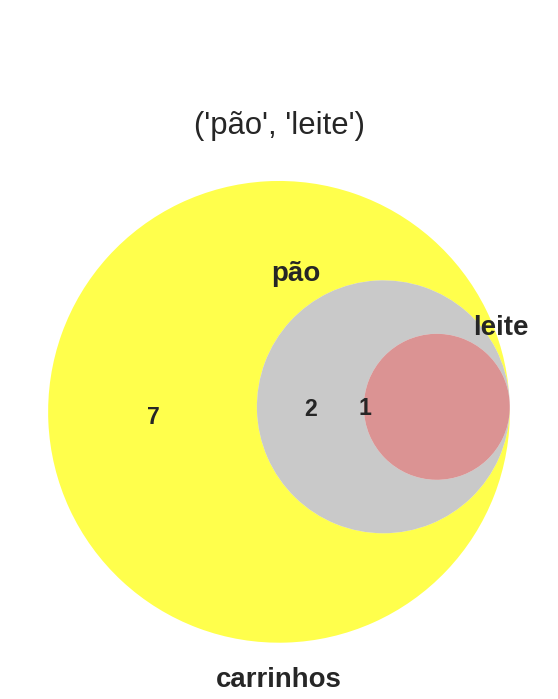

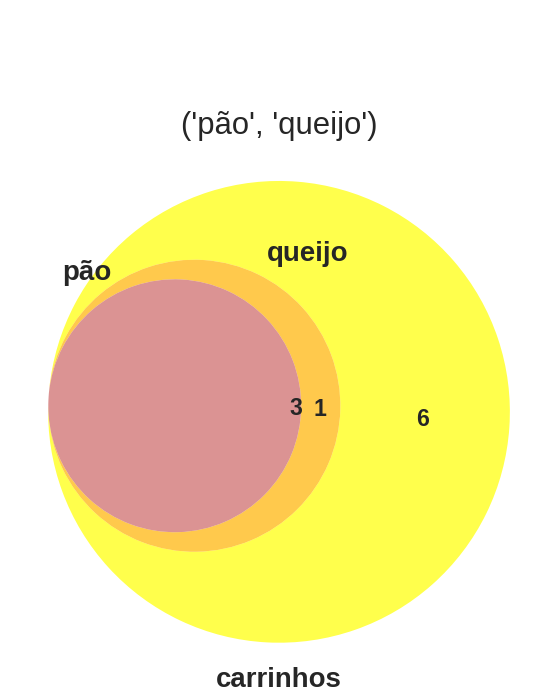

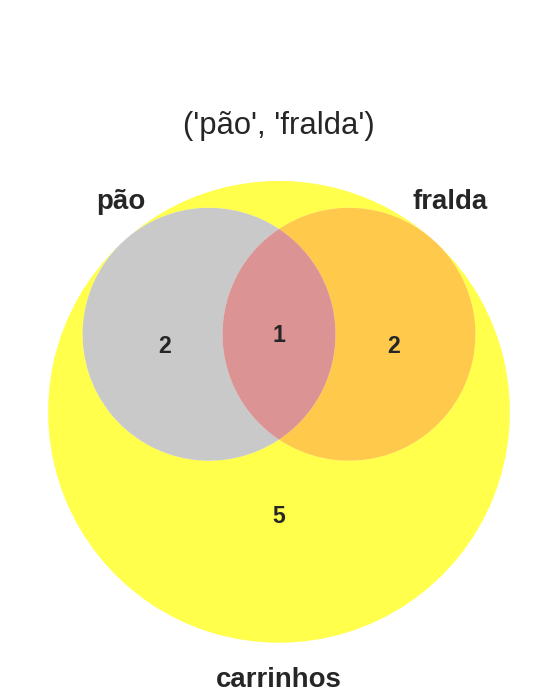

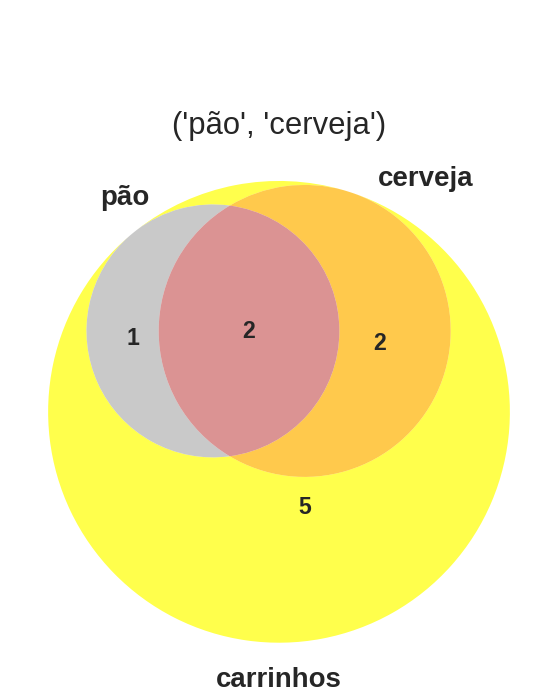

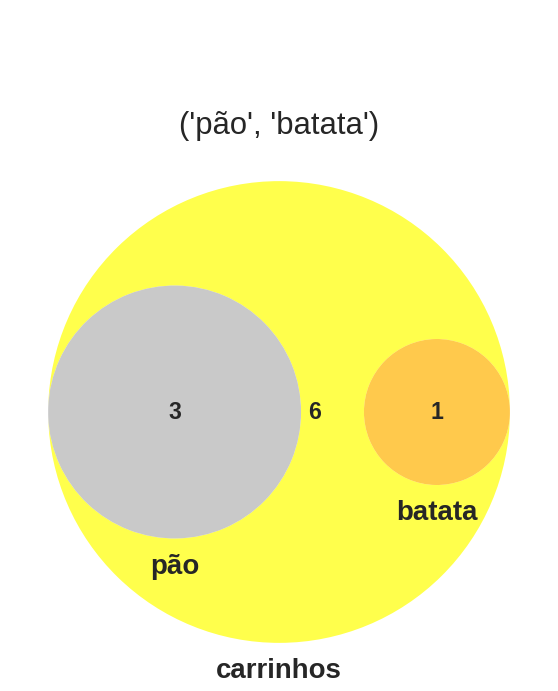

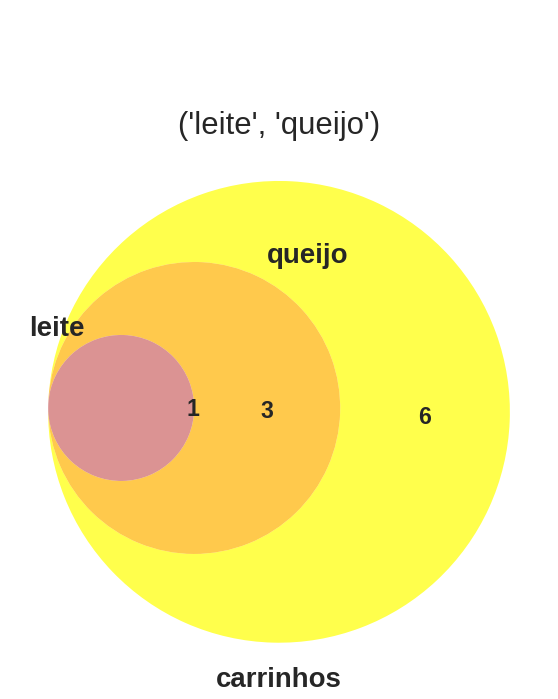

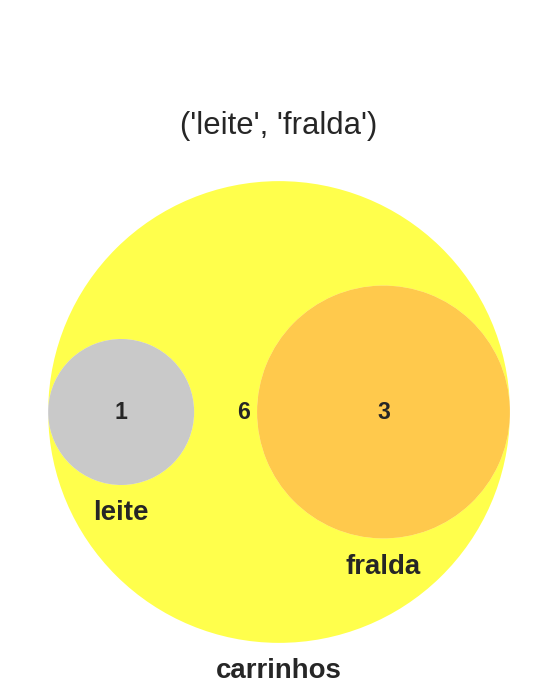

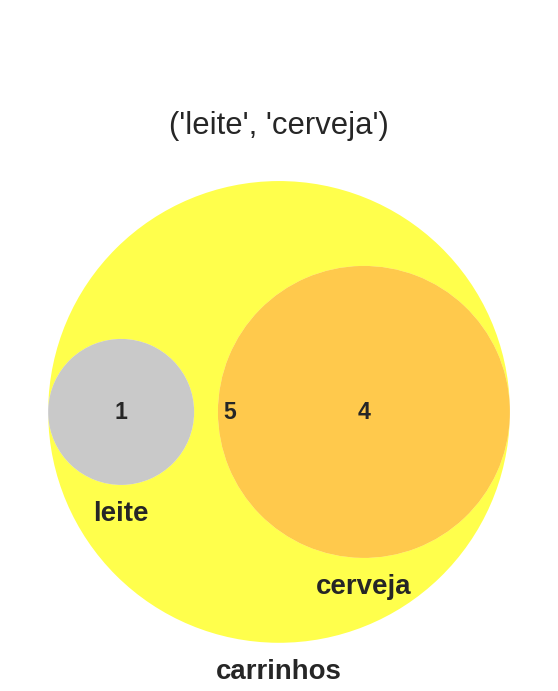

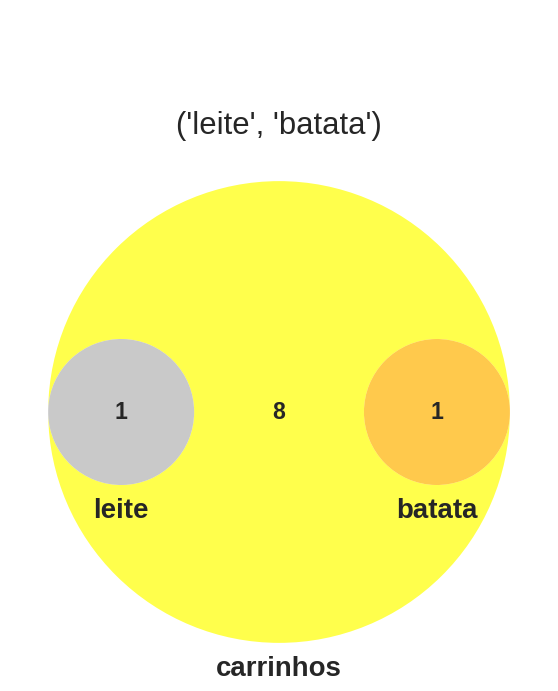

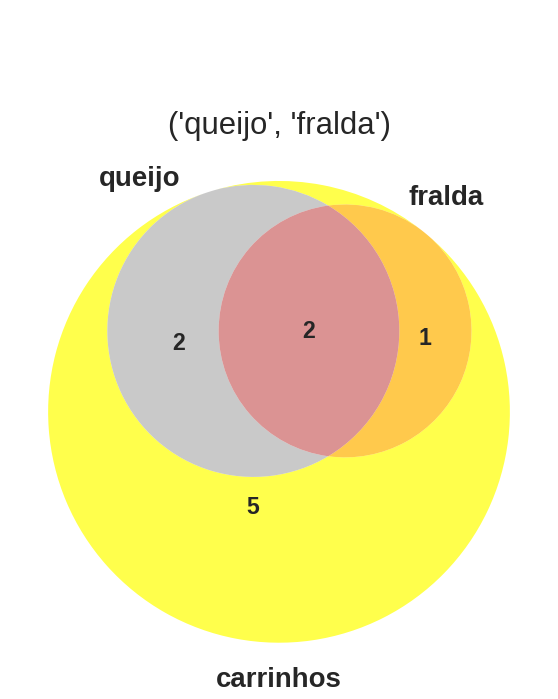

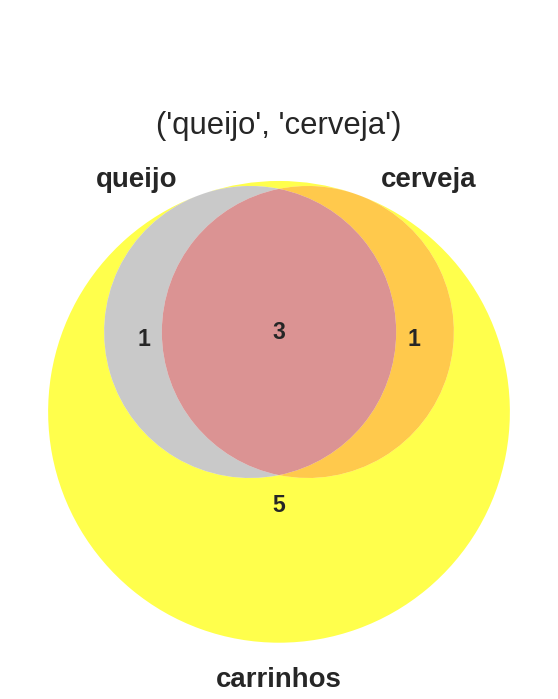

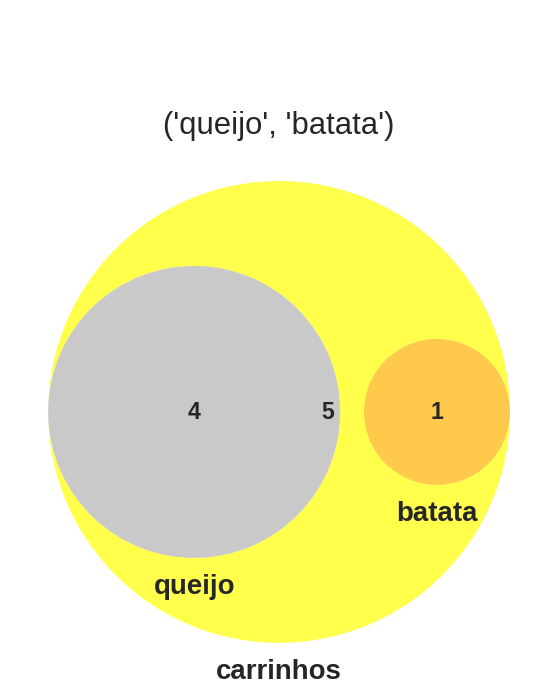

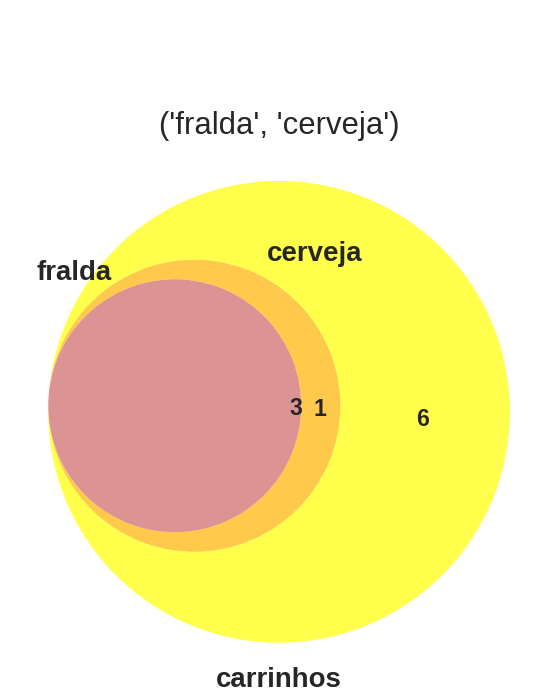

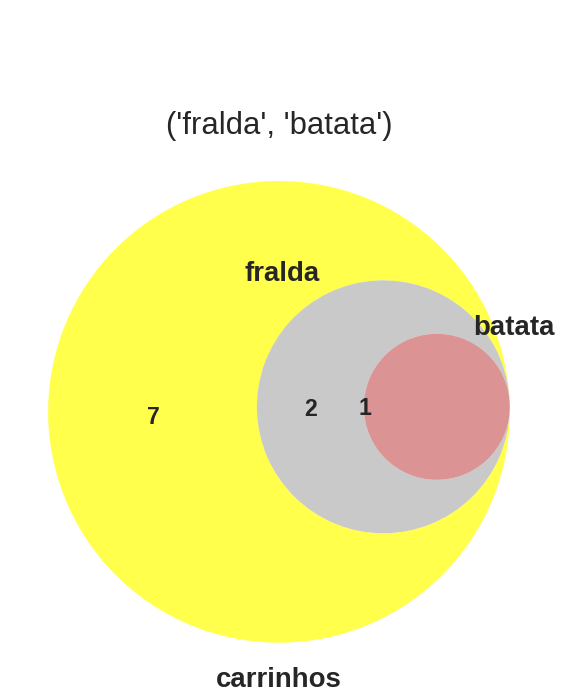

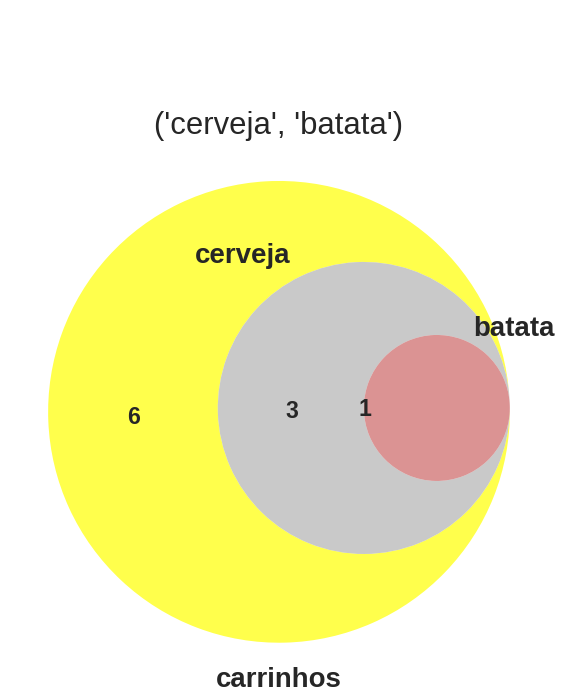

In [221]:
import itertools
import matplotlib

combs = list(itertools.combinations([item for item in ab.index if item not in 'carrinhos'], 2))

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 23}

matplotlib.rc('font', **font)

for i in range(len(combs)):
    plt.figure(figsize=(15,10))
    plt.style.use('seaborn')
    plt.title(str('\n\n\n')+str(combs[i]), fontsize=31)
    venn3(
        [products[combs[i][0]], products[combs[i][1]], products['carrinhos']],
       set_labels=combs[i]+('carrinhos',),
        alpha = .7,
        set_colors=['blue', 'red', 'yellow']
     )
    plt.show()

### Vamos usar o módulo apyori para aplicar este algoritmo

https://github.com/ymoch/apyori

https://zaxrosenberg.com/unofficial-apyori-documentation/

https://pypi.org/project/apyori/

In [332]:
from apyori import apriori

In [32]:
df = pd.read_csv('transaction_data_example.csv', low_memory=False)

In [33]:
df_clean = df.loc[(df['customer_id'].notna()) & (df['product'].notna())].copy()

In [34]:
df_clean.head()

,transaction_id,product,quantity,date,price,customer_id,country
0,536365,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [72]:
df['transaction_id'].unique()[1:10]

array(['536366', '536367', '536368', '536369', '536370', '536371',
       '536372', '536373', '536374'], dtype=object)

In [67]:
# produtos distintos
df.loc[df['transaction_id'].isin(df['transaction_id'].unique()[1:10]), 'product'].str.lower().str.replace("'","")

7                  hand warmer union jack
8               hand warmer red polka dot
9           assorted colour bird ornament
10               poppys playhouse bedroom
11               poppys playhouse kitchen
12      feltcraft princess charlotte doll
13                 ivory knitted mug cosy
14     box of 6 assorted colour teaspoons
15           box of vintage jigsaw blocks
16         box of vintage alphabet blocks
17               home building block word
18               love building block word
19            recipe box with metal heart
20                    doormat new england
21               jam making set with jars
22            red coat rack paris fashion
23         yellow coat rack paris fashion
24           blue coat rack paris fashion
25               bath building block word
26              alarm clock bakelike pink
27               alarm clock bakelike red
28             alarm clock bakelike green
29        panda and bunnies sticker sheet
30                        stars gi

## Gerando a lista de transações com as listas de produtos

In [68]:
lista = df_clean[['transaction_id', 'product']].groupby('transaction_id').apply(lambda x: x['product'].str.lower().str.replace("'","").tolist())
l = []
for i in lista.index:
    l.append(lista[i])

## Inspecionando a lista para os 10 primeiros casos

In [69]:
l[0:10]

[['white hanging heart t-light holder',
  'white metal lantern',
  'cream cupid hearts coat hanger',
  'knitted union flag hot water bottle',
  'red woolly hottie white heart.',
  'set 7 babushka nesting boxes',
  'glass star frosted t-light holder'],
 ['hand warmer union jack', 'hand warmer red polka dot'],
 ['assorted colour bird ornament',
  'poppys playhouse bedroom',
  'poppys playhouse kitchen',
  'feltcraft princess charlotte doll',
  'ivory knitted mug cosy',
  'box of 6 assorted colour teaspoons',
  'box of vintage jigsaw blocks',
  'box of vintage alphabet blocks',
  'home building block word',
  'love building block word',
  'recipe box with metal heart',
  'doormat new england'],
 ['jam making set with jars',
  'red coat rack paris fashion',
  'yellow coat rack paris fashion',
  'blue coat rack paris fashion'],
 ['bath building block word'],
 ['alarm clock bakelike pink',
  'alarm clock bakelike red',
  'alarm clock bakelike green',
  'panda and bunnies sticker sheet',
  's

In [ ]:
regras_associacao = apriori(l[0:6], min_support=0.003, min_confidence=0.2,
                            min_lift=2, min_length=2)

resultados = list(regras_associacao)

In [ ]:
len(resultados)